In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from stratx import featimp
from stratx.partdep import *
from rfpimp import plot_importances
import rfpimp

import shap

%config InlineBackend.figure_formats = ['svg','png']

In [35]:
def synthetic_poly_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    #TODO add noise
    terms = [f"{coeff[i]:.1f}x_{i+1}" for i in range(p)]
    eqn = "y = " + '+'.join(terms)
    return df, coeff, eqn

In [36]:
def synthetic_poly2_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, 2, 10])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] - 3*df['x2'] + 3*df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 - 3 x_2 + 3 x_3^2"

In [37]:
def shap_importances(rf, X):
    shap_values = shap.TreeExplainer(rf).shap_values(X)
    shapimp = np.mean(np.abs(shap_values), axis=0)
    print(shapimp)
    shapI = pd.DataFrame(data={'Feature': X.columns, 'Importance': shapimp})
    shapI = shapI.set_index('Feature')
    shapI = shapI.sort_values('Importance', ascending=False)
    #plot_importances(shapI)
    return shapI

In [72]:
def ginidrop_importances(rf, X):
    ginidrop_I = rf.feature_importances_
    ginidrop_I = pd.DataFrame(data={'Feature': X.columns, 'Importance': ginidrop_I})
    ginidrop_I = ginidrop_I.set_index('Feature')
    ginidrop_I = ginidrop_I.sort_values('Importance', ascending=False)
    return ginidrop_I

In [78]:
def compare_imp(rf,X,y,eqn):
    fig, axes = plt.subplots(1,5,figsize=(10,2))

    I = featimp.importances(X, y)
    plot_importances(I, imp_range=(0,1),ax=axes[0])
    
    shap_I = shap_importances(rf, X)
    plot_importances(shap_I,ax=axes[1])

    gini_I = ginidrop_importances(rf, X)
    plot_importances(gini_I,ax=axes[2])

    perm_I = rfpimp.importances(rf,X,y)
    plot_importances(perm_I,ax=axes[3])
    drop_I = rfpimp.dropcol_importances(rf,X,y)
    plot_importances(drop_I,ax=axes[4])

    axes[0].set_title("Strat Imp")
    axes[1].set_title("SHAP Imp")
    axes[2].set_title("ginidrop Imp")
    axes[3].set_title("Permute column")
    axes[4].set_title("Drop column")
    plt.suptitle(f"${eqn}$")
    fig.tight_layout()
    fig.subplots_adjust(top=.7)

In [79]:
palette = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
    "#ffff99", 
    "#b15928"
]
def plot_all_PD(X,y,eqn=None,min_samples_leaf=5):
    fig, ax = plt.subplots(1,1)
    for i,colname in enumerate(X.columns):
        plot_stratpd(X, y, colname, 'y', ax=ax, min_samples_leaf=min_samples_leaf,
                     show_slope_lines=False,
                     pdp_marker_color=palette[i])
#     uniq_x = np.array(sorted(np.unique(X[:,0])))
#     ax2 = ax.twinx()
    record_x = range(len(y))
    record_x = (record_x - np.mean(record_x)) / np.std(record_x)
    ax.plot(record_x, y, lw=.3, c='k', label='marginal $y$ vs $x^{(i)}$')
    if eqn is not None:
        plt.title(f"${eqn}$")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Synthetic degree 1 polynomial

In [80]:
df, coeff, eqn = synthetic_poly_data(500,3)
df.head()

,x1,x2,x3,y
0,7.0,10.0,4.2,83.431354
1,0.0,8.4,7.9,88.637430
2,9.8,1.7,8.6,82.533753
3,0.8,0.2,1.6,13.001784
4,6.2,6.7,4.5,69.911636


In [81]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)

rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

[ 3.30904342 10.46847226 16.45874191]


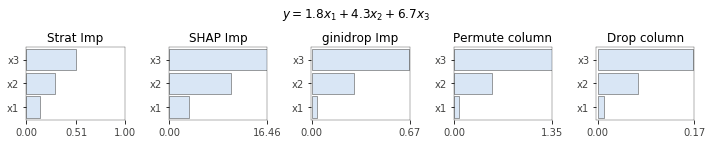

In [82]:
compare_imp(rf,X,y,eqn)

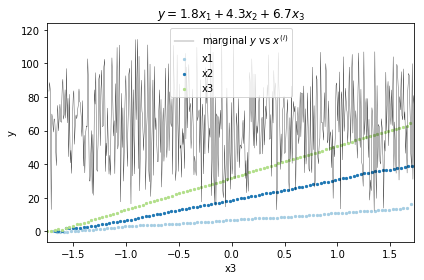

In [83]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial

In [84]:
df, coeff, eqn = synthetic_poly2_data(500,3)
df.head()

,x1,x2,x3,y
0,0.8,9.0,3.7,18.07
1,9.7,0.1,3.9,93.83
2,1.1,4.8,8.7,218.17
3,8.2,5.1,8.7,252.77
4,1.2,4.3,0.3,-6.63


In [85]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

[11.91230839  5.41479481 73.44597277]


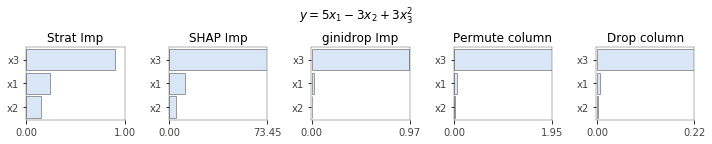

In [86]:
compare_imp(rf,X,y,eqn)

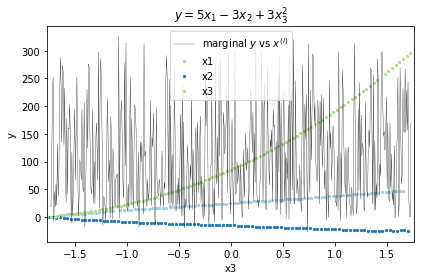

In [87]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial with duplicated column x_3

In [105]:
def synthetic_poly2dup_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, 2, 10])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    df['x3'] = df['x1']  # copy x1 into x3
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] + 3*df['x2'] + df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 + 3 x_2 + x_3^2 where x_3 = x_1"

In [106]:
df, coeff, eqn = synthetic_poly2dup_data(500,3)
df.head()

,x1,x2,x3,y
0,0.8,9.1,0.8,31.94
1,7.7,9.7,7.7,126.89
2,2.8,5.9,2.8,39.54
3,7.2,1.6,7.2,92.64
4,9.8,7.3,9.8,166.94


In [107]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

[17.23157168  6.66947661 22.63577719]


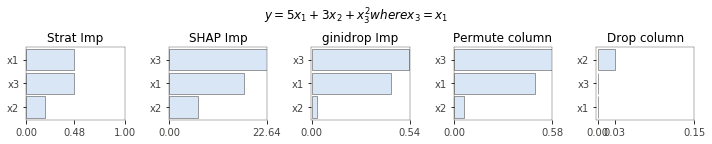

In [108]:
compare_imp(rf,X,y,eqn)

## Synthetic degree 2 polynomial with sine

In [92]:
def synthetic_poly2_sine_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    df['y'] = 5*df['x1'] + 15*np.sin(df['x2']+(n/2)*(2*np.pi)/n) + df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 + 15 sin(x_2) + x_3^2"

In [93]:
df, coeff, eqn = synthetic_poly2_sine_data(500,3)
df.head()

,x1,x2,x3,y
0,9.5,6.0,8.8,129.131232
1,9.1,3.6,4.6,73.297807
2,8.5,5.2,8.6,129.711820
3,9.3,1.2,6.6,76.079414
4,5.0,6.6,8.6,94.286880


In [94]:
X = df.drop('y', axis=1)
y = df['y']
X = featimp.standardize(X)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

[12.01927279  4.56027387 26.66351079]


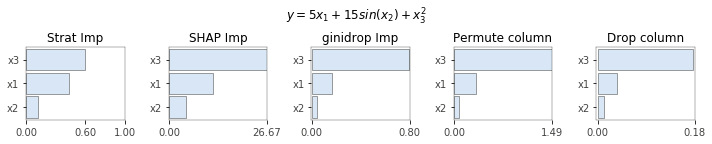

In [95]:
compare_imp(rf,X,y,eqn)

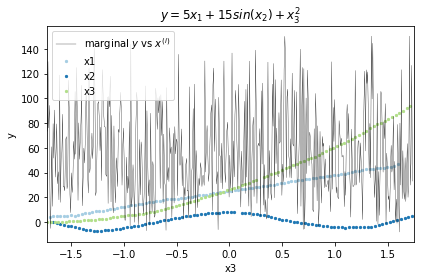

In [96]:
plot_all_PD(X,y,eqn)

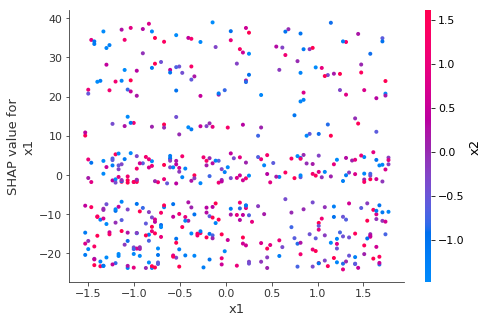

In [59]:
shap.dependence_plot("x1", shap_values, X)

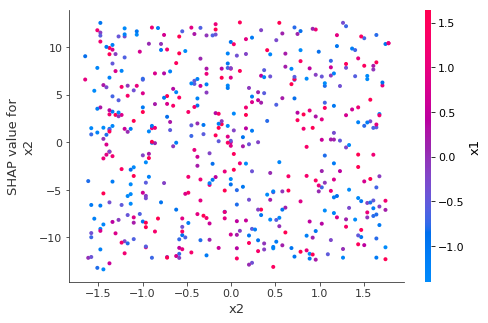

In [60]:
shap.dependence_plot("x2", shap_values, X)

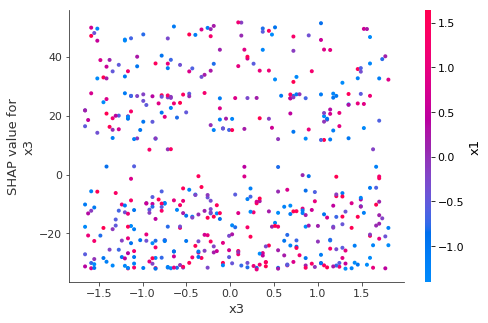

In [61]:
shap.dependence_plot("x3", shap_values, X)

# Playground

(-2, 2)

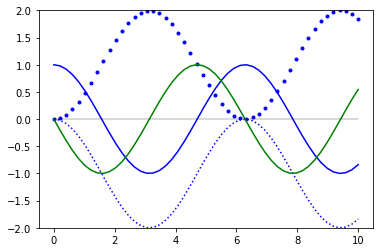

In [62]:
x = np.linspace(0,10)
y = np.cos(x)
y_ = -np.sin(x)

plt.plot(x,y, c='blue')
plt.plot(x,y-y[0], ':', c='blue')
plt.plot(x,np.abs(y-y[0]), '.', c='blue')
plt.plot(x,y_, c='green')
# plt.plot(x,np.abs(y_), ':', c='green')
plt.plot([0,10], [0,0], c='k', lw=.3)
plt.ylim(-2,2)

[<matplotlib.lines.Line2D at 0x10e9a4908>]

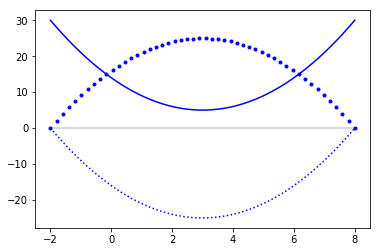

In [63]:
x = np.linspace(-2,8)
y = (x-3)**2+5
plt.plot(x,y, c='blue')
plt.plot(x,y-y[0], ':', c='blue')
plt.plot(x,np.abs(y-y[0]), '.', c='blue')
plt.plot([-2,8], [0,0], c='k', lw=.3)

[<matplotlib.lines.Line2D at 0x1c24a77a90>]

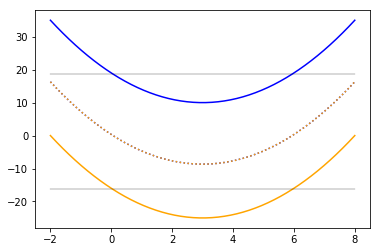

In [64]:
x = np.linspace(-2,8)
y = (x-3)**2+10
y_ = (x-3)**2
#shift = np.mean(y) - np.mean(y_)
plt.plot(x,y, c='blue')
plt.plot(x,y-np.mean(y), ':', c='blue')
plt.plot(x,y-y[0], c='orange')
plt.plot(x,y-y[0]-np.mean(y-y[0]), ':', c='orange')
# plt.plot(x,y_-np.mean(y_), ':', c='orange')
plt.plot([-2,8], [np.mean(y),np.mean(y)], c='k', lw=.3)
plt.plot([-2,8], [np.mean(y-y[0]),np.mean(y-y[0])], c='k', lw=.3)

In [65]:
np.mean(y), np.mean(y_), np.mean(y) - np.mean(y_), y[0]

(18.673469387755105, 8.673469387755103, 10.000000000000002, 35.0)

In [66]:
# ok so subtract mean of y and PD of y then measure/compare area under curve